# Fetch Data

In [65]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from prometheus_api_client import *
from prometheus_api_client import PrometheusConnect
from prometheus_api_client.utils import parse_datetime
import matplotlib.pyplot as plt
from merlion.utils import TimeSeries

In [50]:
# expose service thanos-addons-query as NodePort, check prometheus connection
prom = PrometheusConnect(url="http://127.0.0.1:9090")
prom.check_prometheus_connection()

start_time = datetime(2021, 11, 29, 0, 0, 0, 0)

end_time = datetime(2021, 12, 6, 0, 0, 0, 0)

metric_data = prom.custom_query_range(
    query="sum(rate(http_server_requests_seconds_count{job='product-content', outcome!='SUCCESS'}[5m])) / sum(rate(http_server_requests_seconds_count{job='product-content'}[5m]))",
    step = 60,
    start_time=start_time,
    end_time=end_time)

metric_df = MetricRangeDataFrame(metric_data)
metric_df.head()

metric_df = pd.DataFrame(metric_df)
metric_df.index = pd.to_datetime(metric_df.index, unit='s')

metric_df['value'] = metric_df['value'].astype('float64')

metric_df.to_csv("data.csv")

metric_df


,value
timestamp,
2021-11-28 16:00:00,0.001928
2021-11-28 16:01:00,0.002871
2021-11-28 16:02:00,0.002931
2021-11-28 16:03:00,0.003145
2021-11-28 16:04:00,0.003226
...,...
2021-12-05 15:56:00,0.000209
2021-12-05 15:57:00,0.000283
2021-12-05 15:58:00,0.000608


<AxesSubplot:xlabel='timestamp'>

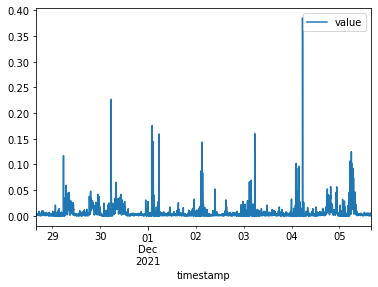

In [66]:
dataset = pd.read_csv('data.csv', index_col="timestamp")
dataset.index = pd.to_datetime(dataset.index)
dataset.head()
dataset.plot()

In [67]:
# anomaly definition: if the failrate is larger
def aggregateDataset(df = dataset, duration=5):
    for i in range(1, duration + 1):
        dataset['value_' + str(i) ] = dataset['value'].shift(-i)
    return df

def labelDataset(df = dataset, threshold=0.02):
    df['label'] = (df > threshold).all(axis=1)
    df['label'] = df['label'].map({True: 1, False: 0})
    return df

dataset = aggregateDataset(dataset, 5)
dataset = labelDataset(dataset, 0.02)
dataset = dataset[['value', 'label']]

In [68]:
train_data = TimeSeries.from_pd(dataset['value'][:int(len(dataset)*0.8)])
test_data = TimeSeries.from_pd(dataset['value'][int(len(dataset)*0.8):])
test_labels = TimeSeries.from_pd(dataset['label'][int(len(dataset)*0.8):])
train_data

                        value
2021-11-28 16:00:00  0.001928
2021-11-28 16:01:00  0.002871
2021-11-28 16:02:00  0.002931
2021-11-28 16:03:00  0.003145
2021-11-28 16:04:00  0.003226
...                       ...
2021-12-04 06:19:00  0.002212
2021-12-04 06:20:00  0.000000
2021-12-04 06:21:00  0.002012
2021-12-04 06:22:00  0.001815
2021-12-04 06:23:00  0.002232

[8064 rows x 1 columns]

# Isolation Tree

In [99]:
from sklearn.ensemble import IsolationForest
from merlion.evaluate.anomaly import TSADMetric
from merlion.post_process.calibrate import AnomScoreCalibrator
from merlion.post_process.threshold import AggregateAlarms
from merlion.transform.moving_average import DifferenceTransform
from merlion.transform.sequence import TransformSequence
from merlion.transform.resample import Shingle
from merlion.utils import UnivariateTimeSeries, TimeSeries

class TyrellIsolationForest():
    
        def __init__(self, 
                     n_estimators=100, 
                     outlier_fraction = 'auto',
                     max_score: float = 1.0, 
                     threshold=None,
                     min_alm_in_window=2,
                     alm_window_minutes=10,
                     alm_suppress_minutes=10,
                     enable_calibrator=False, 
                     enable_threshold=False,
                     enable_preprocess=False):
            self.enable_threshold = enable_threshold
            self.enable_calibrator = enable_calibrator
            self.enable_preprocess =enable_preprocess
            if self.enable_preprocess:
                self.default_transform = TransformSequence([DifferenceTransform(), Shingle(size=2, stride=1)])
            self.calibrator = AnomScoreCalibrator(max_score=max_score)
            if threshold is not None:
                self.threshold = AggregateAlarms(alm_threshold=threshold, 
                                       abs_score=True,
                                       min_alm_in_window = min_alm_in_window,
                                       alm_window_minutes = alm_window_minutes,
                                       alm_suppress_minutes = alm_suppress_minutes)
            # different contamination means different decision_function values, while same score_samples
            # decision_function = score_samples - offset_, offset is relevant with contamination
            # When the contamination parameter is set to “auto”, the offset is equal to -0.5
            # as the scores of inliers are close to 0 and the scores of outliers are close to -1.
            self.model = IsolationForest(n_estimators=n_estimators, 
                                       max_samples="auto", 
                                       #max_samples=1.0, 
                                       random_state=0, 
                                       contamination=outlier_fraction)
        
        def train_pre_process(self, train_data: TimeSeries):
            if not self.enable_preprocess:
                return train_data
            self.default_transform.train(train_data)
            train_data = self.default_transform(train_data)
            return train_data
        
        def train(self, train_data: TimeSeries, anomaly_labels: TimeSeries = None) -> TimeSeries:
            train_data = self.train_pre_process(train_data)
            times, train_values = zip(*train_data.align())
            train_values = np.asarray(train_values)

            self.model.fit(train_values)
            train_scores = -self.model.score_samples(train_values)
            train_scores = TimeSeries({"anom_score": UnivariateTimeSeries(times, train_scores)})
            train_scores = self.train_post_rule(train_scores)
            return train_scores
        
        def train_post_rule(self, anomaly_scores):
            if self.enable_calibrator:
                self.calibrator.train(anomaly_scores)
                anomaly_scores = self.calibrator(anomaly_scores)
            if self.enable_threshold:
                self.threshold.train(anomaly_scores)
                anomaly_scores = self.threshold(anomaly_scores)
            return anomaly_scores
        
        def predict(self, test_data: TimeSeries, test_labels: TimeSeries = None):
            self.test_data = test_data
            self.test_labels = test_labels
            if self.enable_preprocess:
                test_data = self.default_transform(test_data)
                self.test_data = self.test_data[:len(test_data)]
                if self.test_labels:
                    self.test_labels = self.test_labels[:len(test_data)]
            times, test_values = zip(*test_data.align())
            test_values = np.asarray(test_values)
            if not self.enable_calibrator and not self.enable_threshold:
                self.result = self.model.predict(test_values)
            else:
                self.result = -self.model.score_samples(test_values)
            self.result = TimeSeries({"anom_score": UnivariateTimeSeries(times, self.result)})
            if self.enable_calibrator:
                self.result = self.calibrator(self.result)
            if self.enable_threshold:
                self.result = self.threshold(self.result)
            return self.result
        
        def plotPredictResult(self):
            plt.figure(figsize=(20,6))
            plt.plot(self.test_data.to_pd().index, self.test_data.to_pd()['value'], 'r')
            plt.figure(figsize=(20,6))
            plt.plot(self.test_data.to_pd().index, self.result.to_pd(), 'b', label='predict')
            if self.test_labels:
                plt.plot(self.test_data.to_pd().index, self.test_labels.to_pd(), 'g', label='ground truth')
            
        def evaluateModel(self, ground_truth, predict):
            p = TSADMetric.Precision.value(ground_truth=ground_truth, predict=predict)
            r = TSADMetric.Recall.value(ground_truth=ground_truth, predict=predict)
            f1 = TSADMetric.F1.value(ground_truth=ground_truth, predict=predict)
            mttd = TSADMetric.MeanTimeToDetect.value(ground_truth=ground_truth, predict=predict)
            print(f"Precision: {p:.4f}, Recall: {r:.4f}, F1: {f1:.4f}\n"
               f"Mean Time To Detect: {mttd}")
            return {'precision' : p, 'recall' : r, 'F1-score': f1, 'MTTD': mttd}

## SKlearn Isolation Tree without data preprocess and without postprocess

Precision: 0.0053, Recall: 1.0000, F1: 0.0106
Mean Time To Detect: 0 days 00:00:00


{'precision': 0.005324813631522897,
 'recall': 1.0,
 'F1-score': 0.01059322033898305,
 'MTTD': Timedelta('0 days 00:00:00')}

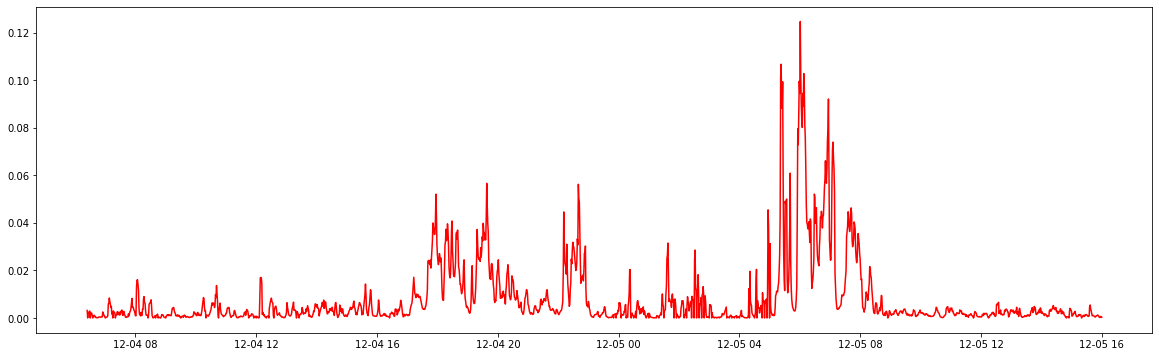

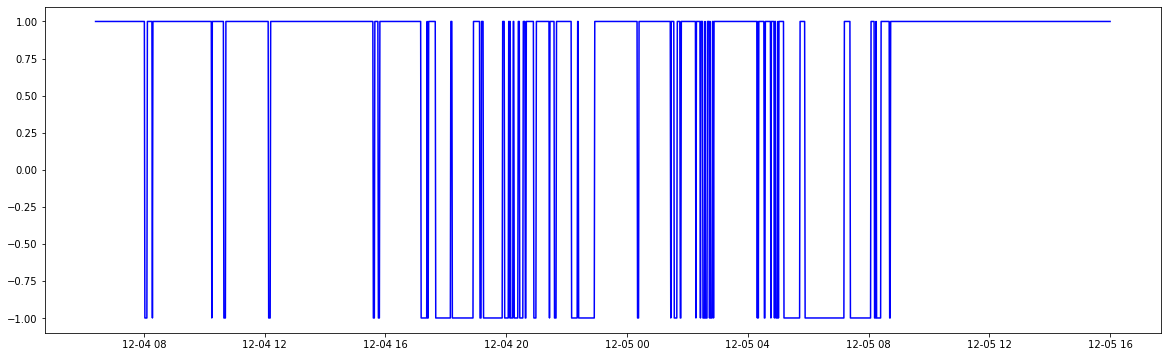

In [70]:
outlier_fraction = 'auto'
n_estimators = 100
model_wo_preprocess_postprocess = TyrellIsolationForest(n_estimators=n_estimators, 
                                                        outlier_fraction = outlier_fraction)
train_scores = model_wo_preprocess_postprocess.train(train_data)
result = model_wo_preprocess_postprocess.predict(test_data)
model_wo_preprocess_postprocess.plotPredictResult()
model_wo_preprocess_postprocess.evaluateModel(test_labels, result)

## Conclusion

The outliers are too many, this would cause alert storm. We need consider use custom label function to aggregate the labels. Next we'll try use some post-process techniques from Merlion library to see how the results would look like.

## SKlearn Isolation Tree without data preprocess but with postprocess

Precision: 0.5556, Recall: 1.0000, F1: 0.7143
Mean Time To Detect: 0 days 00:02:00


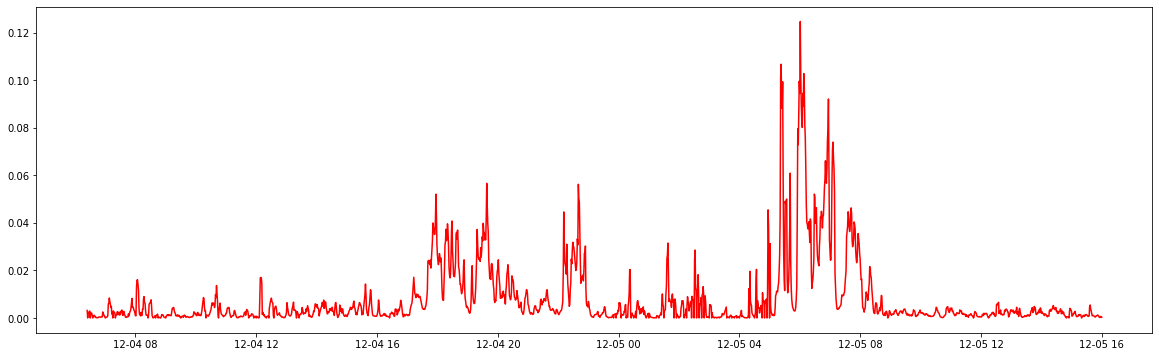

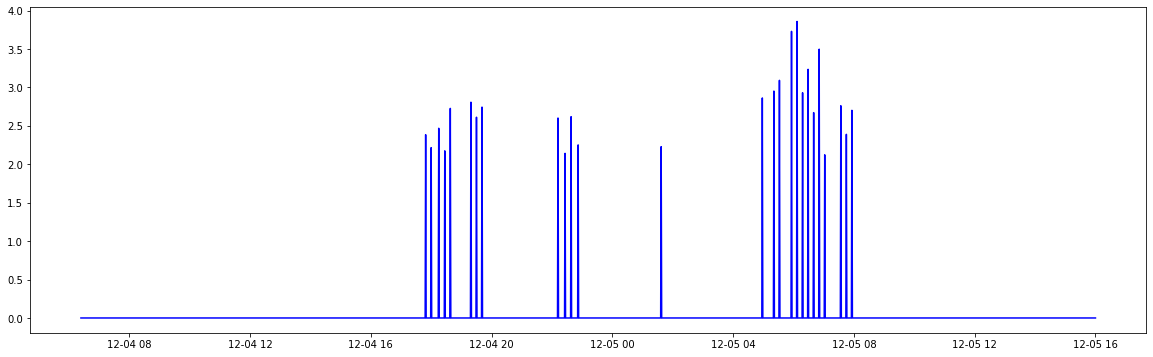

In [11]:
outlier_fraction = 'auto'
n_estimators = 100
model_wo_preprocess_with_postprocess = TyrellIsolationForest(n_estimators=n_estimators, 
                                                        outlier_fraction = outlier_fraction,
                                                        enable_calibrator=True,
                                                        max_score=1.0,
                                                        enable_threshold=True,
                                                        threshold=2.1, 
                                                        min_alm_in_window = 2,
                                                        alm_window_minutes = 10,
                                                        alm_suppress_minutes = 10)
train_scores = model_wo_preprocess_with_postprocess.train(train_data)
result = model_wo_preprocess_with_postprocess.predict(test_data)
model_wo_preprocess_with_postprocess.plotPredictResult()
model_wo_preprocess_with_postprocess.evaluateModel(test_labels, result)

## Conclusion

The results look ok. Next, we add some pre-process techniques provided in Merlion library, to see whether it can bring some improvements. 

## SKlearn Isolation Tree with data preprocess and with postprocess

Precision: 0.3750, Recall: 0.6000, F1: 0.4615
Mean Time To Detect: 0 days 00:04:30


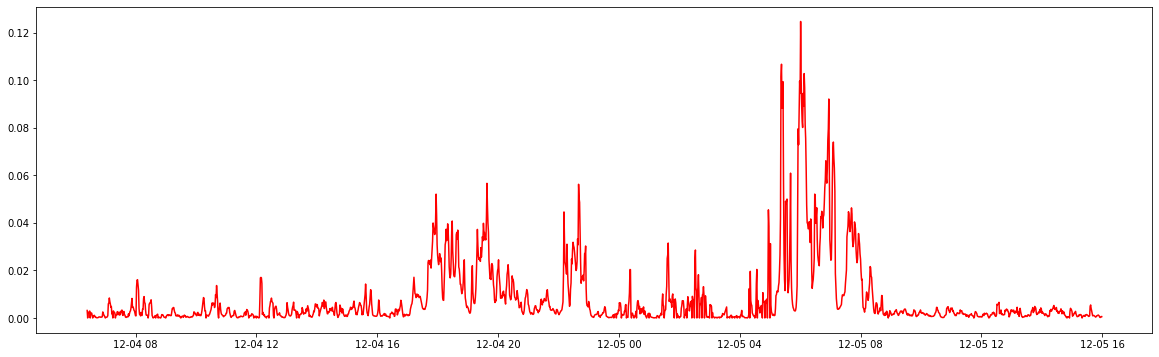

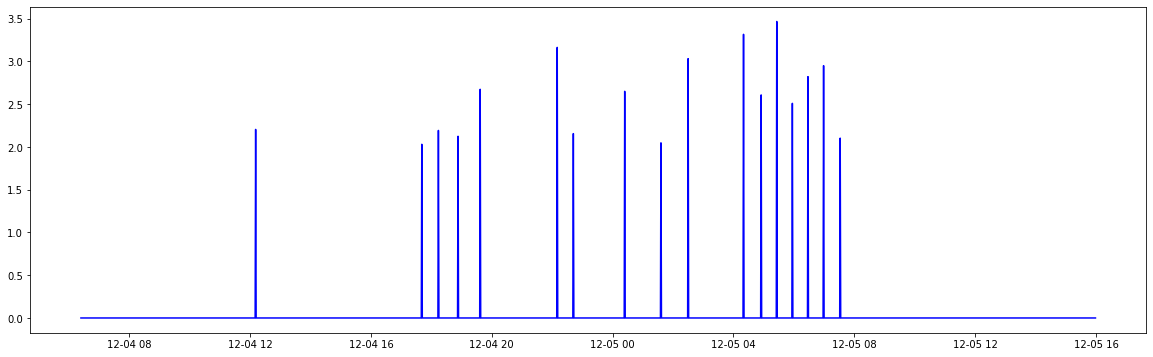

In [12]:
outlier_fraction = 'auto'
n_estimators = 100
model_with_preprocess_with_postprocess = TyrellIsolationForest(n_estimators=n_estimators, 
                                                        outlier_fraction = outlier_fraction,
                                                        enable_calibrator=True,
                                                        max_score=1.0,
                                                        enable_threshold=True,
                                                        threshold=2, 
                                                        min_alm_in_window = 2,
                                                        alm_window_minutes = 30,
                                                        alm_suppress_minutes = 30,
                                                        enable_preprocess=True)
train_scores = model_with_preprocess_with_postprocess.train(train_data)
result = model_with_preprocess_with_postprocess.predict(test_data)
model_with_preprocess_with_postprocess.plotPredictResult()
model_with_preprocess_with_postprocess.evaluateModel(test_labels, result)

## Tune Hyperparameters
Take without preprocess and with postprocess models for example.
### Threshold
Lower threshold means the model would be very sensitive => low precision. If threshold is set to be very high, then precision would become high, a point will be considered as anomalies unless model is very confident. In this case, recall becomes high. 

In [17]:
possible_threshold = [0.5,1.0,1.5,2.0,2.1,2.2,2.3,2.5,3,3.5,4.0,4.5]
outlier_fraction = 'auto'
n_estimators = 100
precisions = []
recalls = []
f1 = []
for threshold in possible_threshold:
    model = TyrellIsolationForest(n_estimators=n_estimators, 
                                                        outlier_fraction = outlier_fraction,
                                                        enable_calibrator=True,
                                                        max_score=1.0,
                                                        enable_threshold=True,
                                                        threshold=threshold, 
                                                        min_alm_in_window = 2,
                                                        alm_window_minutes = 10,
                                                        alm_suppress_minutes = 10)
    train_scores = model.train(train_data)
    result = model.predict(test_data)
    metrics = model.evaluateModel(test_labels, result)
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1.append(metrics['F1-score'])

Precision: 0.0373, Recall: 0.6000, F1: 0.0702
Mean Time To Detect: 0 days 00:06:20
Precision: 0.0577, Recall: 0.6000, F1: 0.1053
Mean Time To Detect: 0 days 00:02:20
Precision: 0.1556, Recall: 0.7000, F1: 0.2545
Mean Time To Detect: 0 days 00:01:00
Precision: 0.5000, Recall: 1.0000, F1: 0.6667
Mean Time To Detect: 0 days 00:01:12
Precision: 0.5556, Recall: 1.0000, F1: 0.7143
Mean Time To Detect: 0 days 00:02:00
Precision: 0.4211, Recall: 0.8000, F1: 0.5517
Mean Time To Detect: 0 days 00:02:30
Precision: 0.5333, Recall: 0.8000, F1: 0.6400
Mean Time To Detect: 0 days 00:02:45
Precision: 0.5333, Recall: 0.8000, F1: 0.6400
Mean Time To Detect: 0 days 00:04:00
Precision: 0.5556, Recall: 0.5000, F1: 0.5263
Mean Time To Detect: 0 days 00:05:48
Precision: 0.7500, Recall: 0.3000, F1: 0.4286
Mean Time To Detect: 0 days 00:11:00
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Mean Time To Detect: 0 days 00:00:00
Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Mean Time To Detect: 0 days 00:00:00


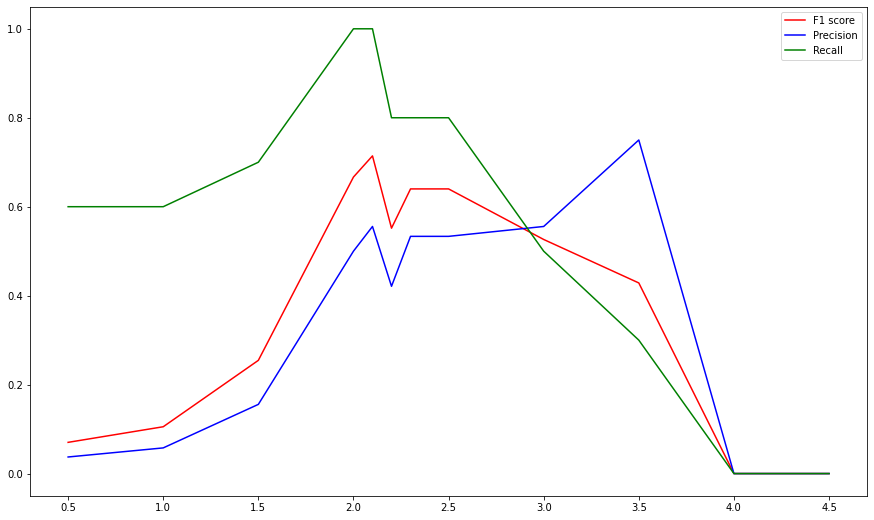

In [24]:
plt.figure(figsize=(15,9))
plt.plot(possible_threshold, f1, 'r', label='F1 score')
plt.plot(possible_threshold, precisions, 'b', label='Precision')
plt.plot(possible_threshold, recalls, 'g', label='Recall')
plt.legend()

### Alarm Window

In [25]:
window_minutes = [4,8,10,12,16,20,24,30,40,50,60,90,120]
outlier_fraction = 'auto'
n_estimators = 100
threshold = 2.1
precisions = []
recalls = []
f1 = []
for window in window_minutes:
    model = TyrellIsolationForest(n_estimators=n_estimators, 
                                                        outlier_fraction = outlier_fraction,
                                                        enable_calibrator=True,
                                                        max_score=1.0,
                                                        enable_threshold=True,
                                                        threshold=threshold, 
                                                        min_alm_in_window = 2,
                                                        alm_window_minutes = window,
                                                        alm_suppress_minutes = window)
    train_scores = model.train(train_data)
    result = model.predict(test_data)
    metrics = model.evaluateModel(test_labels, result)
    precisions.append(metrics['precision'])
    recalls.append(metrics['recall'])
    f1.append(metrics['F1-score'])

Precision: 0.4000, Recall: 1.0000, F1: 0.5714
Mean Time To Detect: 0 days 00:02:24
Precision: 0.5263, Recall: 1.0000, F1: 0.6897
Mean Time To Detect: 0 days 00:02:06
Precision: 0.5556, Recall: 1.0000, F1: 0.7143
Mean Time To Detect: 0 days 00:02:00
Precision: 0.4737, Recall: 0.9000, F1: 0.6207
Mean Time To Detect: 0 days 00:02:53
Precision: 0.4667, Recall: 0.7000, F1: 0.5600
Mean Time To Detect: 0 days 00:02:34
Precision: 0.5333, Recall: 0.8000, F1: 0.6400
Mean Time To Detect: 0 days 00:02:37
Precision: 0.5714, Recall: 0.8000, F1: 0.6667
Mean Time To Detect: 0 days 00:04:07
Precision: 0.4167, Recall: 0.5000, F1: 0.4545
Mean Time To Detect: 0 days 00:05:48
Precision: 0.3636, Recall: 0.4000, F1: 0.3810
Mean Time To Detect: 0 days 00:13:15
Precision: 0.5556, Recall: 0.5000, F1: 0.5263
Mean Time To Detect: 0 days 00:08:48
Precision: 0.4286, Recall: 0.3000, F1: 0.3529
Mean Time To Detect: 0 days 00:14:40
Precision: 0.4286, Recall: 0.3000, F1: 0.3529
Mean Time To Detect: 0 days 00:03:40
Prec

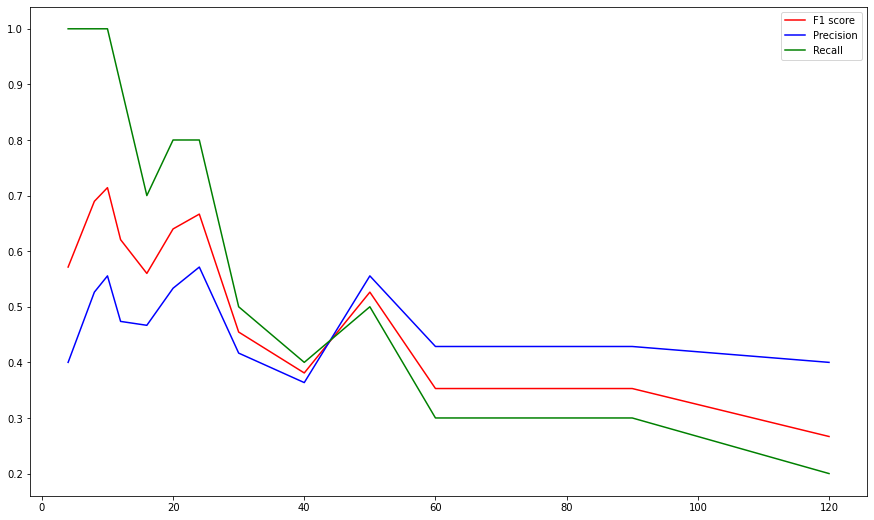

In [26]:
plt.figure(figsize=(15,9))
plt.plot(window_minutes, f1, 'r', label='F1 score')
plt.plot(window_minutes, precisions, 'b', label='Precision')
plt.plot(window_minutes, recalls, 'g', label='Recall')
plt.legend()

# Public Datasets
## Real known cause anomaly data

In [118]:
from ts_datasets.anomaly import NAB
from ts_datasets import anomaly

# This is a time series with anomalies in both the train and test split.
# time_series and metadata are both time-indexed pandas DataFrames.
time_series, metadata = NAB(subset="realKnownCause")[3]

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/i330955/Documents/git/Merlion/data/nab/realKnownCause/ec2_request_latency_system_failure.csv (index 2) has timestamp duplicates. Kept first values.
Time series /Users/i330955/Documents/git/Merlion/data/nab/realKnownCause/machine_temperature_system_failure.csv (index 3) has timestamp duplicates. Kept first values.


Precision: 0.4286, Recall: 1.0000, F1: 0.6000
Mean Time To Detect: 1 days 00:03:20


{'precision': 0.42857142857142855,
 'recall': 1.0,
 'F1-score': 0.6,
 'MTTD': Timedelta('1 days 00:03:20')}

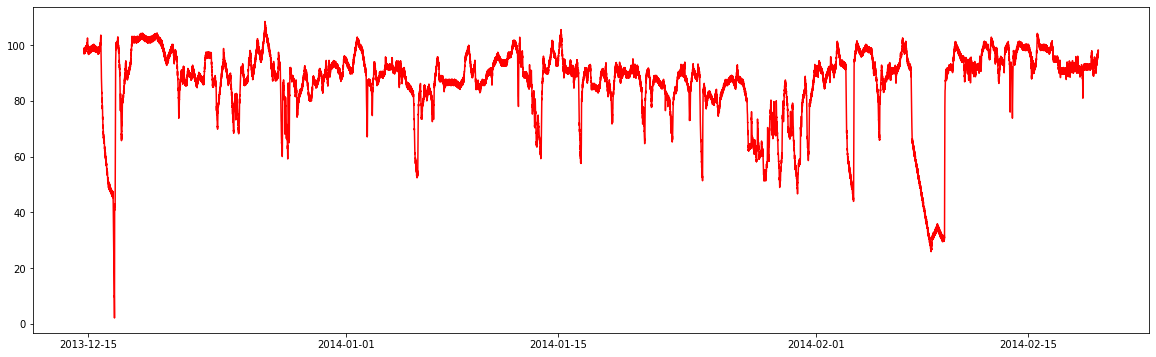

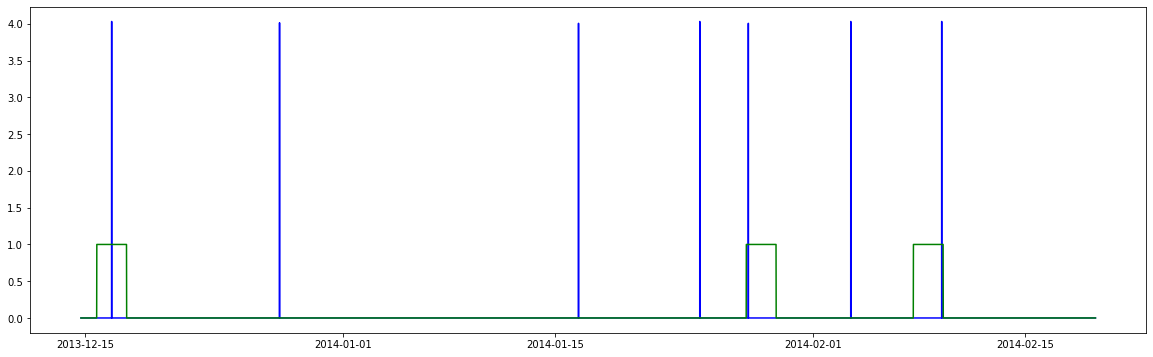

In [127]:
outlier_fraction = 'auto'
n_estimators = 100
model_realKnownCause = TyrellIsolationForest(n_estimators=n_estimators, 
                                            outlier_fraction = outlier_fraction,
                                            enable_calibrator=True,
                                            max_score=1.0,
                                            enable_threshold=True,
                                            threshold=4, 
                                            min_alm_in_window = 0,
                                            alm_window_minutes = 60,
                                            alm_suppress_minutes = 120,
                                            enable_preprocess = True)
train_scores = model_realKnownCause.train(train_data)
result = model_realKnownCause.predict(test_data, test_labels)
model_realKnownCause.plotPredictResult()
model_realKnownCause.evaluateModel(test_labels, result)

By tuning parameters, the results are better to the results that have been achieved by SalesForce (https://github.com/salesforce/Merlion/blob/main/examples/anomaly/1_AnomalyFeatures.ipynb). There are some differences, the reason might be that IsolationForest in Merlion by default uses train_lables to `set the post-rule's threshold`. In summary, IsolationForest does not perform so well in this public dataset.

## AWS CloudWatch Data

In [146]:
time_series, metadata = NAB(subset="realAWSCloudwatch")[3]

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/i330955/Documents/git/Merlion/data/nab/realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv (index 8) has timestamp duplicates. Kept first values.
Time series /Users/i330955/Documents/git/Merlion/data/nab/realAWSCloudwatch/ec2_network_in_5abac7.csv (index 11) has timestamp duplicates. Kept first values.


Precision: 0.0833, Recall: 1.0000, F1: 0.1538
Mean Time To Detect: 0 days 04:40:00


{'precision': 0.08333333333333333,
 'recall': 1.0,
 'F1-score': 0.15384615384615385,
 'MTTD': Timedelta('0 days 04:40:00')}

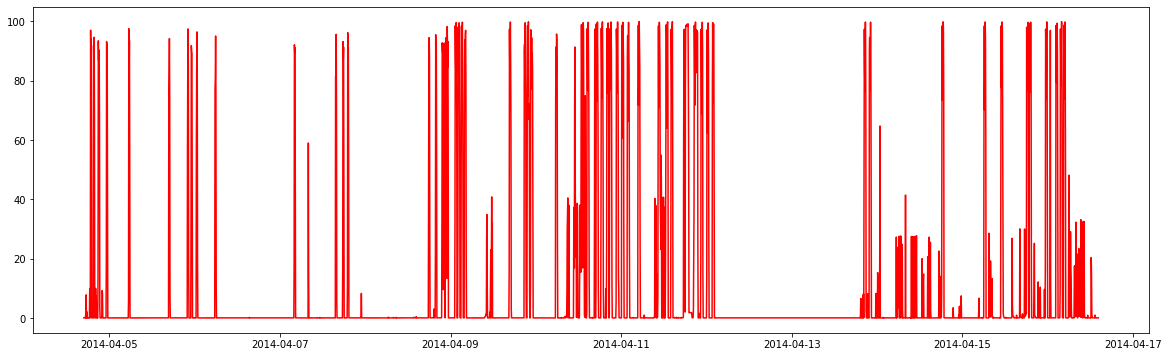

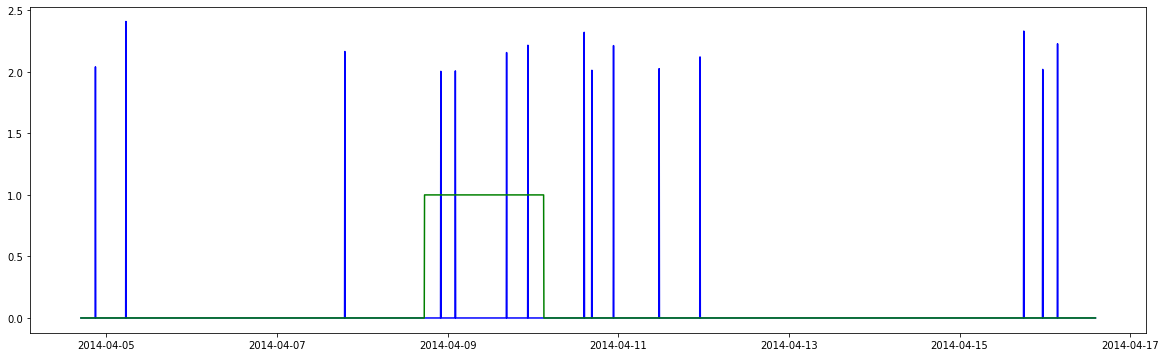

In [181]:
outlier_fraction = 'auto'
n_estimators = 100
model_realAWSCloudwatch = TyrellIsolationForest(n_estimators=n_estimators, 
                                                outlier_fraction = outlier_fraction,
                                                enable_calibrator=True,
                                                max_score=1.0,
                                                enable_threshold=True,
                                                threshold=2, 
                                                min_alm_in_window = 10,
                                                alm_window_minutes = 14,
                                                alm_suppress_minutes = 120,
                                                enable_preprocess= True)
train_scores = model_realAWSCloudwatch.train(train_data)
result = model_realAWSCloudwatch.predict(test_data, test_labels)
model_realAWSCloudwatch.plotPredictResult()
model_realAWSCloudwatch.evaluateModel(test_labels, result)

## Real Traffic Data

In [138]:
time_series, metadata = NAB(subset="realTraffic")[3]

# Get training split
train = time_series[metadata.trainval]
train_data = TimeSeries.from_pd(train)
train_labels = TimeSeries.from_pd(metadata[metadata.trainval].anomaly)

# Get testing split
test = time_series[~metadata.trainval]
test_data = TimeSeries.from_pd(test)
test_labels = TimeSeries.from_pd(metadata[~metadata.trainval].anomaly)

Time series /Users/i330955/Documents/git/Merlion/data/nab/realTraffic/occupancy_t4013.csv (index 3) has timestamp duplicates. Kept first values.
Time series /Users/i330955/Documents/git/Merlion/data/nab/realTraffic/speed_t4013.csv (index 6) has timestamp duplicates. Kept first values.


Precision: 1.0000, Recall: 1.0000, F1: 1.0000
Mean Time To Detect: 0 days 07:30:00


{'precision': 1.0,
 'recall': 1.0,
 'F1-score': 1.0,
 'MTTD': Timedelta('0 days 07:30:00')}

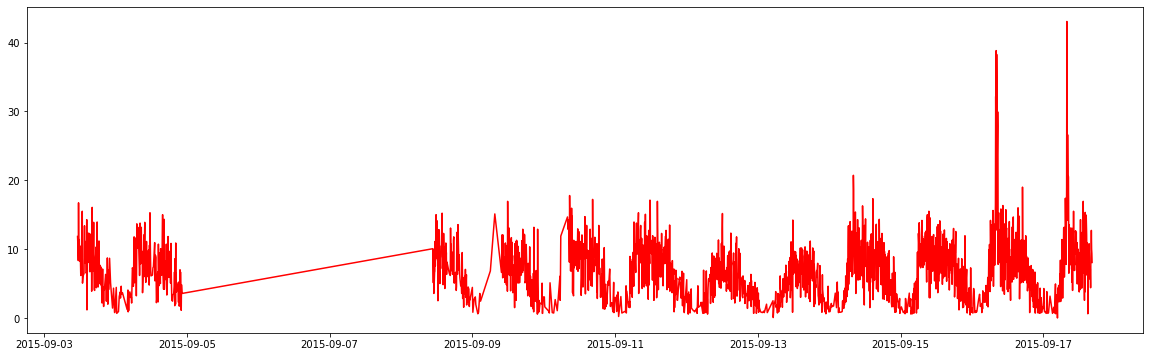

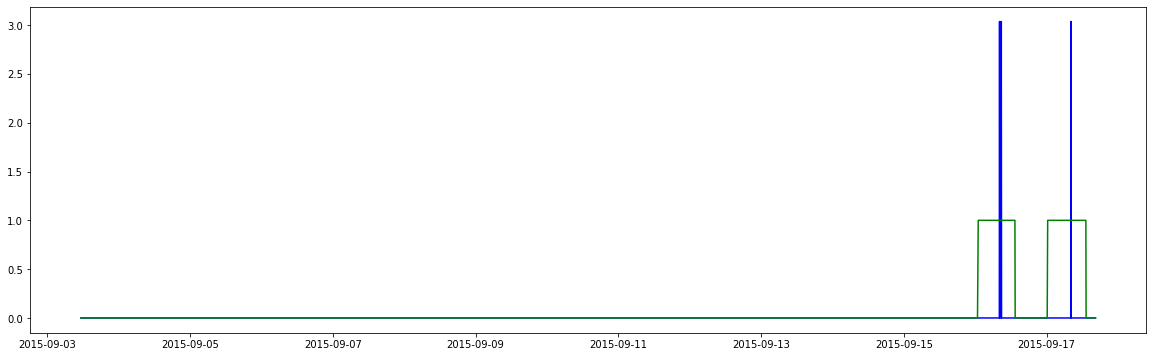

In [145]:
outlier_fraction = 'auto'
n_estimators = 100
model_realTraffic = TyrellIsolationForest(n_estimators=n_estimators, 
                                        outlier_fraction = outlier_fraction,
                                        enable_calibrator=True,
                                        max_score=1.0,
                                        enable_threshold=True,
                                        threshold=2.5, 
                                        min_alm_in_window = 5,
                                        alm_window_minutes = 15,
                                        alm_suppress_minutes = 30 )
train_scores = model_realTraffic.train(train_data)
result = model_realTraffic.predict(test_data, test_labels)
model_realTraffic.plotPredictResult()
model_realTraffic.evaluateModel(test_labels, result)

## Isolation Tree using SalesForce Merlion

This part is just completely using Isolation Forest in SalesForce Merlion library to do anomaly detection. 

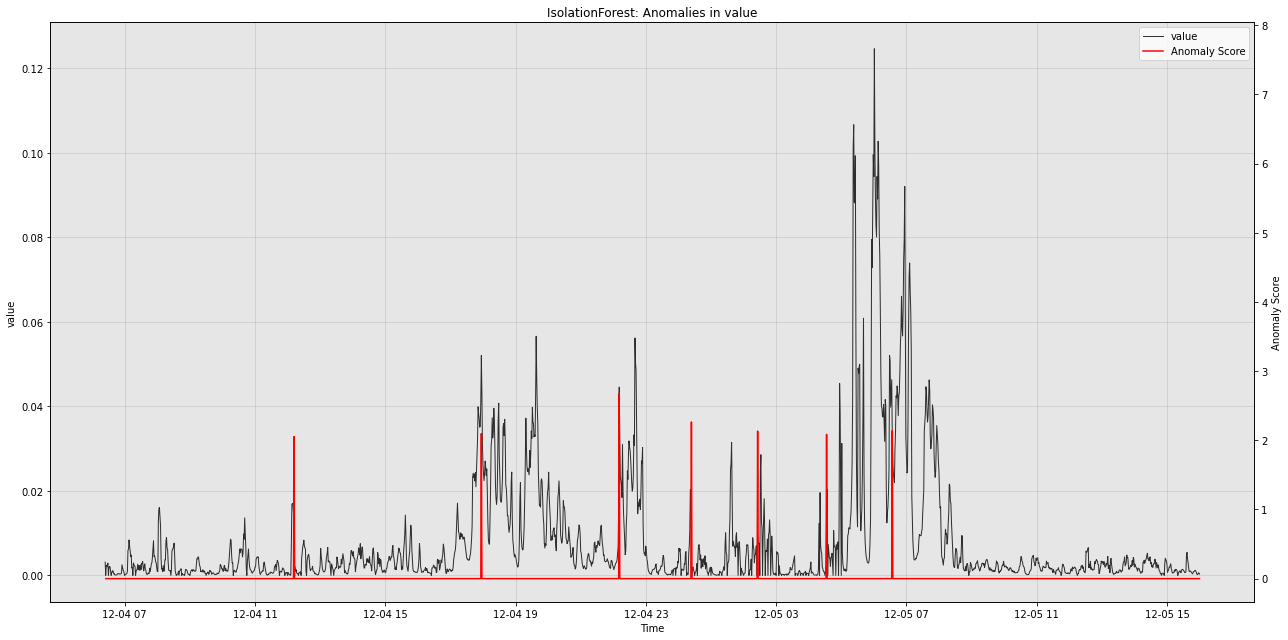

In [232]:
from merlion.models.anomaly.isolation_forest import IsolationForest, IsolationForestConfig
from merlion.post_process.threshold import AggregateAlarms

config = IsolationForestConfig(threshold=AggregateAlarms(alm_threshold=2))
model_merlion  = IsolationForest(config)

train_scores_merlion = model_merlion.train(train_data=train_data, anomaly_labels=None)

scores_merlion = model_merlion.get_anomaly_score(test_data)
labels_merlion = model_merlion.get_anomaly_label(test_data)

fig, ax = model_merlion.plot_anomaly(
    time_series=test_data,
    filter_scores=True, 
    plot_time_series_prev=True,
    figsize=(1800,900))

plt.show()
print()

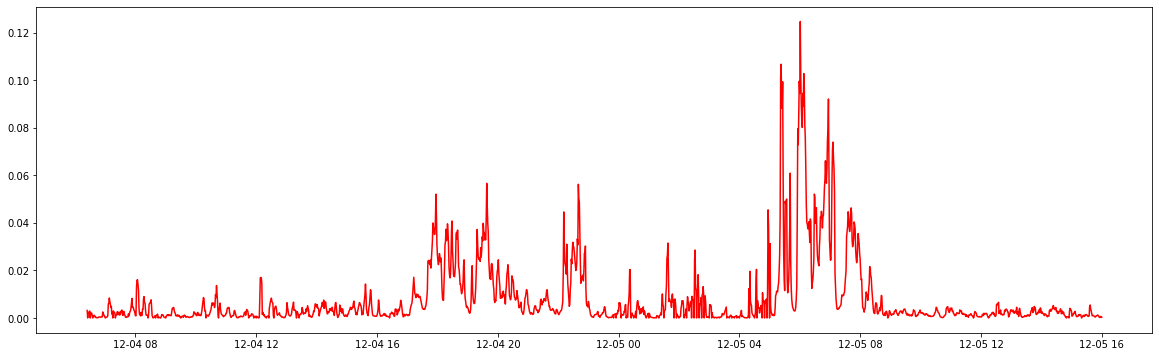

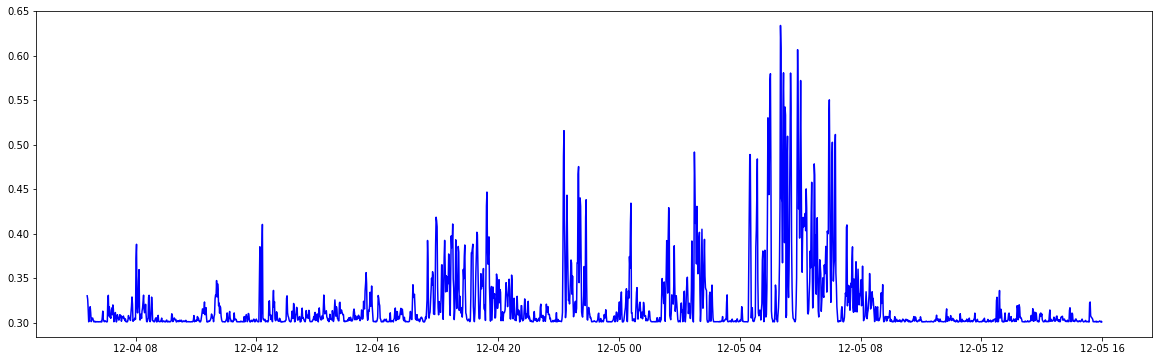

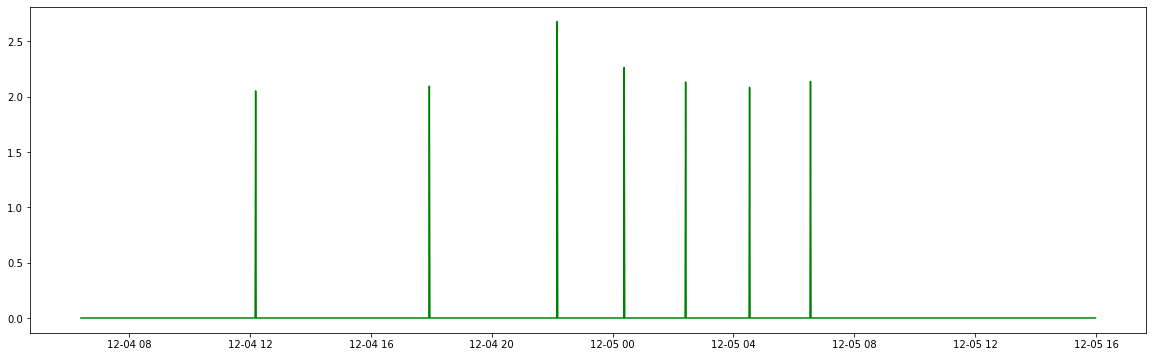

In [70]:
plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index, test_data.to_pd()['value'], 'r')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:2016], scores_merlion.to_pd(), 'b')

plt.figure(figsize=(20,6))
plt.plot(test_data.to_pd().index[:2016], labels_merlion.to_pd(), 'g')

In [245]:
evaluateModel(test_labels, labels_merlion)

Precision: 0.2857, Recall: 0.2000, F1: 0.2353
Mean Time To Detect: 0 days 00:11:00
